# PA1.1 - Word Embeddings

### Introduction

In this notebook, you will learn how to train your own word embeddings using two approaches, then explore some of the fun things you can do with them.

Word Embeddings are a type of word representation that allows words with similar meaning to have a similar representation. They are a distributed representation for text that is perhaps one of the key breakthroughs for the impressive performance of deep learning methods on challenging natural language processing problems.

For reference and additional details, please go throught the following resources:

1) Chapter 6 of [the SLP3 book](https://web.stanford.edu/~jurafsky/slp3)
2) This [nice writeup by Jay Alammar](https://jalammar.github.io/illustrated-word2vec/).
3) [LSTMs Basics](https://medium.com/linagoralabs/next-word-prediction-a-complete-guide-d2e69a7a09e6)

### Instructions

- Follow along with the notebook, filling out the necessary code where instructed.

- <span style="color: red;">Read the Submission Instructions, Plagiarism Policy, and Late Days Policy in the attached PDF.</span>

- <span style="color: red;">Make sure to run all cells for credit.</span>

- <span style="color: red;">Do not remove any pre-written code.</span>

- <span style="color: red;">You must attempt all parts.</span>

## Part 1 - Implementing `word2vec` [80 points]

In this part, you will implement the `word2vec` algorithm. 

While `word2vec` is more of a _framework_ for learning word embeddings, we will focus on the `SkipGram` model, specifically how it was trained in the original 2013 paper. Your primary references for understanding this algorithm will be the lecture slides, and the two aforementioned links.

You will be working with the *greatest* work of literature ever written: ~~Shrek 2~~ **The Lord of the Rings** - specifically the first book, *The Fellowship of the Ring*. 

While this book is a masterpiece, it can take a while to train embeddings on the entire text. So, we will be working with a subset of the text. 

In [1]:
# Import in the libraries
# Note: you are NOT allowed to use any other libraries or functions outside of these
# Use the following seeds for reproducibility

import os
import re
import random
from typing import List, Union

import numpy as np
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

np.random.seed(22)
random.seed(22)

### Preparing our raw data

In the cell below, you will read in the data as one very long string.

This will be followed by creating a `Dataset` class that will be helpful in working with your dataset when training the model. The `Dataset` class should have the following attributes/methods:

- `__init__(self, data)` - the constructor that takes in the data and initializes the necessary attributes.

- `data` - the data that is passed in. You can apply a very simple preprocessing pipeline: (1) substitute `,!?;-` (i.e. these five punctuation marks) with a period (i.e. `.`), (2) lowercase all the text, and (3) extract only those characters that are alphabetic or a period.

- `tokens` - a list of all the tokens in the data. It might be helpful to use the `nltk.word_tokenize` function already imported for you.

- `vocab` - a set of all the unique tokens in the data. Be sure to sort this and convert it to a list as to have a consistent ordering.

- `vocab_size` - the length of the vocabulary.

- `stoi` - a mapping from the word (s) to their index (i) in the vocab. It is important to have sorted your vocab before creating this mapping.

- `itos` - a mapping from the index (i) to the word (s) in the vocab.

The two mappings will be helpful in fetching your Embeddings later on, since your Embeddings will be a matrix of shape `(vocab_size, embedding_dim)` and the ordering will be dependent on your vocabulary's ordering.

You might find the following boilerplate helpful:
```python
# Substitute the specified punctuation with periods
data = ...

# Tokenize the above plaintext to get a list of tokens
tokens = ...

# Only grab those tokens that are alphabetic or a period (can use .isalpha() here, and a == check for '.') - a list comprehension might be helpful
tokens = ...

# Lowercase all the tokens
tokens = ...
```

In [2]:
# Read in the data
with open("The Fellowship of the Ring.txt") as f:
    data = f.read()

print(data[:200]) # print out the first 200 chars
len(data)

J. R. R. Tolkien 聴 The Lord Of The Rings. (1/4)
-----------------------------------------------


     THE LORD OF THE RINGS

              by

     J. R. R. TOLKIEN



 Part 1: The Fellowship of the 


1024531

In [3]:
class Dataset:

    def __init__(self, data: str):

        data = re.sub(r'[,!?;-]', '.', data)
        data = data.lower()
        data = ''.join([char if char.isalpha() or char == '.' else ' ' for char in data])

        self.tokens = word_tokenize(data)
        self.vocab = sorted(set(self.tokens))
        self.vocab_size = len(self.vocab)
        self.stoi = {word: idx for idx, word in enumerate(self.vocab)}
        self.itos = {idx: word for idx, word in enumerate(self.vocab)}
    
    def __len__(self):
        return len(self.tokens)

dataset = Dataset(data)
print(f"Number of tokens in dataset: {len(dataset)}")
print(f"Vocabulary size: {dataset.vocab_size}")

Number of tokens in dataset: 215905
Vocabulary size: 9394


### Creating our dataset

Now for the fun part of the dataset preparation: creating the windows!

<center>
<img src="https://jalammar.github.io/images/word2vec/skipgram-sliding-window-5.png">
</center>

Recall in class you learned about sliding a window over the text to create the `(context, target)` pairs. You will implement this in the function below. 

We will adopt the following convention: the target word is at the center of a window, and the context words are the words surrounding the target word, with `ctx_size` tokens on either side.

You will implement this to work with a list of tokens (whether that be in string-form, or as indices). The function should return a list of tuples, where each tuple is a pair of the form `(context, target)`.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>The `range` function will return you an iterator where you can specify the start and final indices, as well as the jumps in between. Use this in constructing your for loop.</li>
    <li>One easy way to do this is to begin the loop at the position corresponding to the first center word, then to grab the words to the left and the right in one list. After doing this, your loop moves to the next iter. Be careful with the starting and end iteration variables for your loop.</li>
</ul>
</p>

In [4]:
def get_windows(
        data: List[Union[str, int]], 
        ctx_size: int
    ):
    '''
    Generates the windows to be used later for dataset creation

    Takes in a list of tokens (as strings or integers/indices) and a context size.
    This slides a window of size 2*ctx_size + 1 over the data, producing
    a list of context words and corresponding target words.

    Note that ctx_size is the number of context words on EITHER side of the center word.
    '''
    outside_words = []
    center_words = []

    # Iterate over the data with a sliding window
    for i in range(ctx_size, len(data) - ctx_size):
        # The center word is the current word
        center_words.append(data[i])
        # Context words are the words around the center word
        context = data[i - ctx_size:i] + data[i + 1:i + ctx_size + 1]
        outside_words.append(context)
    
    return outside_words, center_words

# Test the function
owords, cwords = get_windows(
    word_tokenize("hello how are you. i am under the water. please help me."),
    2
)

for i in range(len(owords)):
    print(f"{owords[i]} ---> {cwords[i]}")

# Verify the test case
assert owords[1] == ['how', 'are', '.', 'i'] and cwords[1] == 'you' and len(owords) == 11, \
    "Test failed"

print("Test passed!")


['hello', 'how', 'you', '.'] ---> are
['how', 'are', '.', 'i'] ---> you
['are', 'you', 'i', 'am'] ---> .
['you', '.', 'am', 'under'] ---> i
['.', 'i', 'under', 'the'] ---> am
['i', 'am', 'the', 'water'] ---> under
['am', 'under', 'water', '.'] ---> the
['under', 'the', '.', 'please'] ---> water
['the', 'water', 'please', 'help'] ---> .
['water', '.', 'help', 'me'] ---> please
['.', 'please', 'me', '.'] ---> help
Test passed!


Before we move on to creating our model, recall that a key component of the algorithm was **Negative Sampling** so that our model was able to see occurences of words that _didn't_ appear in the context. We will implement this in the next part.

Your `sample_neg_word` is a utility function that will continue sampling a word from the specific vocabulary until it is not the word you have specified. 

When actually implementing the negative sampling, you will sample tokens that are _not_ the center word only - many implementations ignore the exclusion of the context words, so we will do this same simplification here.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>You can use the `np.random.choice` function to sample an element from a list.</li>
    <li>You can think about running a loop where you keep sampling until you have something that isn't the word to exclude. This is the only check you must make.</li>
</ul>
</p>

In [ ]:
# To create the dataset, we need to get positive and negative samples according to the windows made

def sample_neg_word(to_exclude: str,
                    vocab: List[str]):
        while True:
            sample_word = np.random.choice(vocab)

            if sample_word != to_exclude:

             return sample_word

### Implementing the actual model

Now you will make use of the `Dataset` class and the `sample_neg_word` function to implement the `SkipGram` model.

Recall the steps of the model:

1. Randomly initialize two matrices: `W` and `C` of shape `(vocab_size, embedding_dim)`. These will be your center/target word and context embeddings respectively.

2. Being looping through each `(context, target)` pair in your dataset.

    2.1. For each pair, sample `K` negative words from the vocabulary.

    2.2. Compute the loss for the context and target word, as well as the negative samples.

    2.3. Compute the gradients for the context and target word, as well as the `K` negative samples.

    2.4. For each of these computed gradients, update the corresponding embeddings.

3. Repeat this process for `num_epochs`.


Recall the formulas for the Loss function and the gradients:

$$L_{CE} = -\log \sigma(c_{pos} \cdot w) - \sum_{i=1}^{K} \log \sigma(-c_{neg_i} \cdot w)$$

$$\frac{\partial L_{CE}}{\partial w} = [\sigma(c_{pos} \cdot w) - 1]c_{pos} + \sum_{i=1}^{K} [\sigma(c_{neg_i} \cdot w)]c_{neg_i}$$

$$\frac{\partial L_{CE}}{\partial c_{pos}} = [\sigma(c_{pos} \cdot w) - 1]w$$

$$\frac{\partial L_{CE}}{\partial c_{neg_i}} = \sigma(c_{neg_i} \cdot w)w$$

Where $c_{pos}$ is the context word, $w$ is the target word, and $c_{neg_i}$ is the $i^{th}$ negative sample.

#### Implementation notes

- You will be implementing all of this in the `word2vec` class, inside the `fit` function. Your embedding matrices will be initialized in the `__init__` function, according to the arguments passed in.

- You **must** print out your loss after every epoch (i.e. after every pass through the dataset). If you have implemented everything perfectly, you should see the loss decreasing over time, with no numerical overflows/underflows or the like.

- Your `fit` function will return the list of losses over each epoch - this will be used to visualize the training process.

- <font size="3" color="red"><b>Do not tamper with code you haven't been permitted to modify.</b></font>

In [6]:
# Create the data
# The dataset is very large, so we will only use the first 2000 tokens for now
# There will be 3 words on each side of the center word
context_words, target_words = get_windows(
    dataset.tokens[:2000], 
    ctx_size=3
)

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>A simple (but slightly inefficient) way to implement this would be to use two `for` loops (ignoring the one for sampling the negative words): one for the center word/window, an inner one for each context word so you have a (ctx, target) pair. This is done since you are passing the windows as they are into the function.</li>
    <li>Be VERY careful about which variable is a string, and which is the corresponding index in the vocab. You can use the `encode` function to move from string to index.</li>
    <li>Print out the shapes or use `assert` statements to ensure the shapes are the way you'd expect them. Broadcasting can mess things up if you're not careful.</li>
    <li>Never forget: the gradients that are being calculated will ONLY update the embeddings for the corresponding tokens in the matrices, NOT THE ENTIRE MATRIX.</li>
    <li>An easy way to do this is to make a matrix of zeros representing the gradients for one of the Embedding matrices. When you create the gradient vector(s) for the target/context/negative samples, you can simply replace the corresponding row in that zeros matrix with that vector. The update equation will be very easy to implement.</li>
    <li>If you're running into overflows/underflows or numerical instability, there is something wrong with your implementation. If you're sure everything is correct, double-check your equations with the lecture slides - one wrong sign for a gradient cost me an hour of debugging ;-;</li>
</ul>
</p>

In [35]:
import numpy as np
from typing import List, Dict, Union

def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))

class word2vec:
    def __init__(self, vocab_size: int, stoi: Dict[str, int], emb_dim: int):
        self.vocab_size = vocab_size
        self.stoi = stoi
        self.emb_dim = emb_dim
        self.W = np.random.randn(vocab_size, emb_dim) * 0.01
        self.C = np.random.randn(vocab_size, emb_dim) * 0.01

    def __call__(self, x: int) -> np.ndarray:
        return (self.W[x] + self.C[x]) / 2
    
    def encode(self, x: Union[str, List[str]]) -> Union[int, List[int]]:
        return [self.stoi[i] for i in x] if isinstance(x, list) else self.stoi[x]

    def fit(self, 
            context_words: List[List[str]], 
            target_words: List[str], 
            num_epochs: int = 5, 
            learning_rate: float = 0.01, 
            K: int = 22):
        losses = []

        for epoch in range(num_epochs):
            epoch_loss = 0.0

            for target_word, context in zip(target_words, context_words):
                target_idx = self.encode(target_word)
                context_indices = self.encode(context)

                w = self.W[target_idx]
                c_pos = self.C[context_indices]
                neg_indices = np.random.choice(
                    self.vocab_size, size=K, replace=True
                )

                c_neg = self.C[neg_indices]
                pos_score = sigmoid(np.dot(c_pos, w))
                neg_score = sigmoid(-np.dot(c_neg, w))
                loss = -np.sum(np.log(pos_score)) - np.sum(np.log(neg_score))
                epoch_loss += loss
                grad_w = np.sum((pos_score - 1)[:, np.newaxis] * c_pos, axis=0) + \
                         np.sum(neg_score[:, np.newaxis] * c_neg, axis=0)
                
                grad_c_pos = (pos_score - 1)[:, np.newaxis] * w
                grad_c_neg = neg_score[:, np.newaxis] * w
                self.W[target_idx] -= learning_rate * grad_w
                self.C[context_indices] -= learning_rate * grad_c_pos
                self.C[neg_indices] -= learning_rate * grad_c_neg

            epoch_loss /= len(target_words)
            print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}")
            losses.append(epoch_loss)

        return losses

w2v_model = word2vec(vocab_size=dataset.vocab_size,
                      stoi=dataset.stoi,
                      emb_dim=100)

Epoch 1/10 - Loss: 19.4064
Epoch 2/10 - Loss: 19.3868
Epoch 3/10 - Loss: 19.2442
Epoch 4/10 - Loss: 18.9079
Epoch 5/10 - Loss: 18.4771
Epoch 6/10 - Loss: 17.9040
Epoch 7/10 - Loss: 16.9502
Epoch 8/10 - Loss: 15.4549
Epoch 9/10 - Loss: 13.6598
Epoch 10/10 - Loss: 12.4426


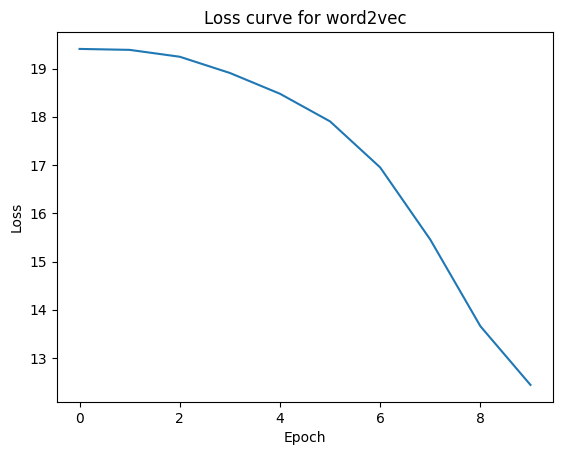

In [36]:
losses = w2v_model.fit(context_words,
                       target_words,
                       num_epochs=10)

# Plot the loss curves
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss curve for word2vec")
plt.show()

**Question:** How does contrastive learning improve the quality of word embeddings by distinguishing between similar and dissimilar pairs?

**Answer:** Contrastive learning enhances word embeddings by maximizing similarity between related words while minimizing similarity between unrelated words, which helps the model learn meaningful semantic relationships between words.

**Question:** Why is contrastive loss effective in learning meaningful word embeddings, and how does it guide the model to improve embeddings?

**Answer:** Contrastive loss is effective because it forces the model to differentiate between similar and dissimilar words. This approach enhances the semantic quality of embeddings, ensuring that words appearing in similar contexts are mapped closer together while unrelated words are pushed apart.

### Cosine Similarity

Hopefully you were able to implement and train the model successfully!

Now to actually examine the embeddings you've trained. We will do one small exercise involving checking the similarity of pairs of words in the vocabulary.

This means you will need to implement the Cosine Similarity function. Recall that the Cosine Similarity between two vectors $u$ and $v$ is given by:
$$ \text{Cosine Similarity}(u, v) = \frac{u \cdot v}{||u|| \cdot ||v||} $$

You will implement this in the `cosine_similarity` function below. You will then use this function on a series of predefined word pairs to see how similar they are in the embedding space: this entails that they showed up in similar contexts in the text.

Since most people are not cultured enough to have read the Lord of the Rings, here are some notes to make sense of what you _should_ see:

- `Frodo` and `Sam` are best friends, so they should have a high similarity.

- `Gandalf` has been referred to as Gandalf the `White`.

- `Frodo` must make an arduous journey to `Mordor`.

- `Aragorn` is close to Frodo, but hasn't been to his home of the `Shire`.

In [37]:
def cosine_similarity(u, v):
    
    dot_product = np.dot(u, v)
    norm_u = np.linalg.norm(u)
    norm_v = np.linalg.norm(v)
    if norm_u == 0 or norm_v == 0:
        return 0.0
    
    sim = dot_product / (norm_u * norm_v)
    return sim

print(cosine_similarity(
    w2v_model.W[dataset.stoi["frodo"]],
    w2v_model.C[dataset.stoi["sam"]]
))

print(cosine_similarity(
    w2v_model.W[dataset.stoi["gandalf"]],
    w2v_model.C[dataset.stoi["white"]]
))

print(cosine_similarity(
    w2v_model.W[dataset.stoi["mordor"]],
    w2v_model.C[dataset.stoi["frodo"]]
))

print(cosine_similarity(
    w2v_model.W[dataset.stoi["shire"]],
    w2v_model.C[dataset.stoi["aragorn"]]
))

-0.9511197171462302
0.8070931042132881
0.8939031121662927
0.8640068303981189


In this section, we perform word vector arithmetic to solve the analogy "king - man + woman ≈ queen." By calculating the cosine similarity between the resulting vector and all other word embeddings, we identify the most similar words to the computed result. This helps evaluate how well the embeddings capture semantic relationships.

In [40]:
def get_analogous_word(word1, word2, word3, model, top_n=5):
    """ Returns the top N words that solve the analogy: word1 - word2 + word3 """
    
    idx1, idx2, idx3 = model.stoi[word1], model.stoi[word2], model.stoi[word3]
    
    embeddings = (model.W + model.C) / 2         # Use the average of W and C embeddings
    
    vec1 = embeddings[idx1]                      # Get the embeddings for the words
    vec2 = embeddings[idx2]
    vec3 = embeddings[idx3]
    
    result_vector = vec1 - vec2 + vec3           # Perform the vector arithmetic
    
    similarities = np.dot(embeddings, result_vector) / (np.linalg.norm(embeddings, axis=1) * np.linalg.norm(result_vector))
    most_similar_indices = np.argsort(similarities)[::-1][:top_n]      # Get the indices of the most similar word
    return [list(model.stoi.keys())[i] for i in most_similar_indices if list(model.stoi.keys())[i] not in [word1, word2, word3]]    # Return the top N most similar words

analogy_results = get_analogous_word('king', 'man', 'woman', w2v_model, top_n=5)
print(f'Analogy result: king - man + woman ≈ {analogy_results}')

Analogy result: king - man + woman ≈ ['chapter', 'writing', 'last', 'shadow']


**Visualization of Word Embeddings for Analogy Task Using PCA**

In this section, we will visualize the word embeddings for the words "king," "man," "woman," and "queen" by projecting them into a 2D space using PCA. This will help us assess whether the learned embeddings capture the semantic relationships between these words

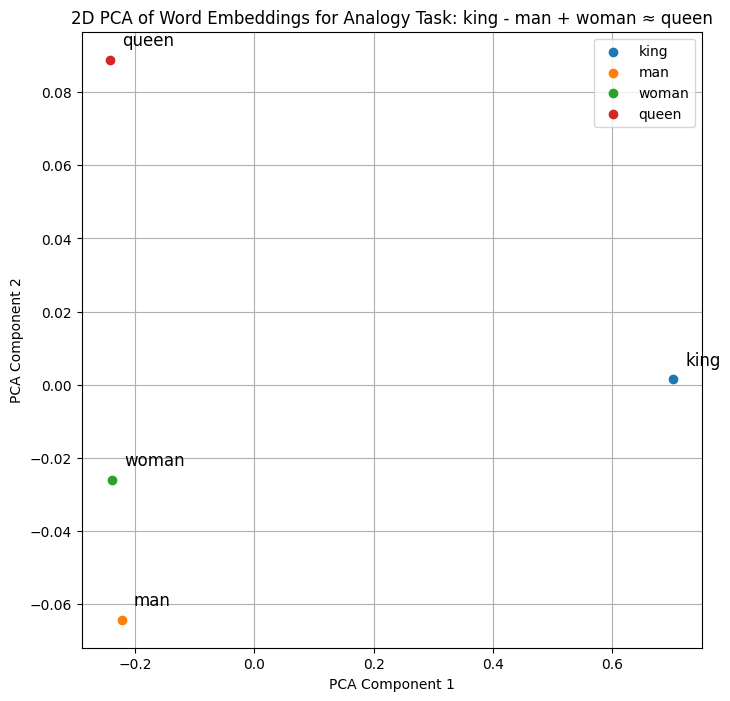

In [41]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

words = ['king', 'man', 'woman', 'queen']
embeddings_for_words = [w2v_model.W[w2v_model.stoi[word]] for word in words]
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings_for_words)

x_std, y_std = np.std(reduced_embeddings, axis=0)
offset_x = x_std * 0.05
offset_y = y_std * 0.05

plt.figure(figsize=(8, 8))
for i, word in enumerate(words):
    plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1], label=word)
    plt.text(reduced_embeddings[i, 0] + offset_x, reduced_embeddings[i, 1] + offset_y, 
             word, fontsize=12, ha='left', va='bottom')

plt.title('2D PCA of Word Embeddings for Analogy Task: king - man + woman ≈ queen')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.legend()
plt.show()


**Question:** Comment on how the quality of the embeddings impacts the ability to represent such analogies in the embedding space. Do the visualizations suggest the embeddings learned by your model reflect meaningful semantic relationships?

**Answer:** The quality of word embeddings plays a key role in how well they can capture relationships between words. Good embeddings group similar words together, so related words like dog and cat end up close in the space. This is especially important for analogies, like King - Man + Woman should be close to Queen.

When we visualize these embeddings, we should see words that are related being close together. If the embeddings can’t capture these relationships or analogies don’t work, it means the model needs improvement. Overall, well-trained embeddings reflect real-world semantic connections and make analogies work as expected.

# Fin.